# Training a Linear Model to Predict Length of Stay

The [Population Health Management Solution](https://github.com/Azure/cortana-intelligence-population-health-management) uses U-SQL queries in Data Lake Analytics to apply trained models to input data. The solution copies pre-trained models to an Azure Data Lake Store account (under the folder `forphmdeploymentbyadf`) for this purpose. In this notebook, we provide the code used to generate the models.

Running this notebook will create the models used in this solution and store them in a folder named `myLOSmodelsfolder` in your current working directory.

## Outline <a id="BackToTop"></a>

  * [Problem Description](#probdesc)
  * [Get Data](#getdata)
  * [Data Description](#datadesc)
  * [Data Exploration](#dataexp)
  * [Feature Engineering](#featureeng)
  * [Create the Model](#model)
  * [Results](#results)

## Problem Description  <a id="probdesc"></a>
### Why predict the length of a hospital stay?

Recent legislative changes have standardized payments for procedures performed, regardless of the number of days a patient actually spends in the hospital. Hospitals are therefore strongly incentivized to use resources more efficiently and find ways to accommodate more patients with the same volume of resources. An accurate prediction of each patient's length of stay can help hospitals:
1. Manage bed occupancy 
2. Effectively schedule elective admissions   
3. Improve patient satisfaction during their hospital stay   

Extended lengths of stay costs hospitals millions of dollars a year. By identifying patients at risk for an extended stay, they can take proactive measures to formulate a treatment plan to reduce the expected length of stay.

### When should the prediction be used?  

Hospitals want to predict the length of each patient's stay at the time of admission and provide this information to the admitting nurse or staff. Our model is trained using encounter-level records for a million or so patients from 23 hospitals (obtained from the Healthcare Cost and Utilization Project, or [HCUP](https://www.hcup-us.ahrq.gov/)) and is suitable for use on similar patient populations, though we recommend that hospitals retrain the model using their own historical patient data for best results. To be applied to newly-admitted patients, the model must be trained using only features that are available for each patient at the time of their admission.

 [Back To Top](#BackToTop)

<a id="getdata"></a>
## Get Data

Here, we download copies of the training data (~2 GB) from the web to your current working directory. This will likely take a few minutes, depending on your bandwidth:

In [1]:
# clear workspace and collect garbage
rm(list=ls())
gc()

Sys.time()
url1 <- "https://phm.blob.core.windows.net/models/core_data.csv"
url2 <- "https://phm.blob.core.windows.net/models/charges_data.csv"
url3 <- "https://phm.blob.core.windows.net/models/severity_data.csv"
url4 <- "https://phm.blob.core.windows.net/models/dxpr_data.csv"

pathd <- getwd()
dest1 <- paste(pathd, "/core_data.csv", sep='')
dest2 <- paste(pathd, "/charges_data.csv", sep='')
dest3 <- paste(pathd, "/severity_data.csv", sep='')
dest4 <- paste(pathd, "/dxpr_data.csv", sep='')

download.file(url1, dest1)
download.file(url2, dest2)
download.file(url3, dest3)
download.file(url4, dest4)
Sys.time()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,440810,23.6,750400,40.1,592000,31.7
Vcells,814395,6.3,1650153,12.6,966319,7.4


[1] "2017-06-12 15:56:50 EDT"

[1] "2017-06-12 16:00:39 EDT"

We now read the input files into memory (this will likely take a few minutes, given the combined size of the files):

In [2]:
Sys.time()
dat_core <- read.csv(dest1)
dat_chrg <- read.csv(dest2)
dat_sevr <- read.csv(dest3)
dat_dxpr <- read.csv(dest4)
Sys.time()

[1] "2017-06-12 16:02:17 EDT"

[1] "2017-06-12 16:05:35 EDT"

Confirm that the input files were downloaded and read fully by checking the data dimensions:

In [3]:
dim(dat_core) # expected: 1103172 x 248
dim(dat_chrg) # expected: 1103172 x 155
dim(dat_sevr) # expected: 1103172 x 30
dim(dat_dxpr) # expected: 1103172 x 180

[1] 1103172     248

[1] 1103172     155

[1] 1103172      30

[1] 1103172     180

Merge the input files and delete the intermediate variables:

In [4]:
dat <- merge(merge(merge(dat_sevr, dat_chrg, by="KEY"), dat_core, by="KEY"), dat_dxpr, by="KEY")
dim(dat) # expected: 1103172 x 610
rm(dat_core, dat_chrg, dat_sevr, dat_dxpr)

[1] 1103172     610

 [Back To Top](#BackToTop)

<a id="datadesc"></a>
## Data Description  

We list the columns contained in the dataset below. A full description of the columns in this dataset can be found in the [data dictionary](https://www.hcup-us.ahrq.gov/db/state/siddist/siddistvarnote2013.jsp).

In [ ]:
names(dat)

We perform a few sanity checks on the integrity of the downloaded data, ensuring that the month column contains the values for months and so on:

In [71]:
unique(dat$AYEAR) 
unique(dat$AMONTH) 
length(unique(dat$AMONTH))
unique(dat$FEMALE)

[1] 2016

[1]  8  3  9  5  4  6 12  2  1 10  7 11

[1] 12

[1] Female Male  
Levels: Female Male

The dataset currently contains 610 columns, but some are not suitable for use with our model because they are not available at the time of a patient's admission (when the length-of-stay prediction will be made). We will use just the following 135 columns for building the length-of-stay model: 

In [7]:
cols_demographic <- c('AGE', 'FEMALE', 'RACE', 'MEDINCSTQ', 'PSTATE', 'ZIP', 'HOSPST', 'PAY1', 'PAY2', 'PAY3') 
cols_admitinfo <- c('KEY', 'VisitLink', 'DSHOSPID', 'ATYPE', 'AMONTH', 'PointOfOriginUB04', 'TRAN_IN')
cols_Diagnosis_present_on_admission <- grep('DXPOA', names(dat), value=T)
cols_ECode_present_on_admission <- grep('E_POA', names(dat), value=T)
cols_ICD9_CM_Chronic_Condition_Indicators <- grep('^CHRON[0-9]', names(dat), value=T)
cols_Chronic_Condition_Indicators_BodySystem <- grep('^CHRONB', names(dat), value=T)
cols_comorbidity_measure_ICD9_CMcodes <- grep('^CM_', names(dat), value=T)
cols_primaryDiagnosis <- c('DX1', 'DXCCS1', 'DXMCCS1')
cols_counts <- c('NDX', 'NCHRONIC')
cols_Target <- c('LOS')
cols4los <- c(cols_demographic, cols_admitinfo, cols_Diagnosis_present_on_admission, cols_ECode_present_on_admission, 
              cols_ICD9_CM_Chronic_Condition_Indicators, cols_Chronic_Condition_Indicators_BodySystem,
              cols_comorbidity_measure_ICD9_CMcodes, cols_primaryDiagnosis, cols_counts, cols_Target)
length(cols4los)

[1] 135

We now reduce the dataset to just the columns of interest:

In [8]:
dat4los <- dat[, cols4los]
dim(dat4los)

[1] 1103172     135

 [Back To Top](#BackToTop)

## Data Exploration  <a id="dataexp"></a>

### Categorical features

The dataset contains 13 categorical features. Below, we enumerate these features and show their possible values:

In [ ]:
cat_cols <- c('DSHOSPID', 'FEMALE', 'RACE', 'ATYPE', 'AMONTH', 'PointOfOriginUB04', 'TRAN_IN',
              'MEDINCSTQ', 'PSTATE', 'PAY1', 'DXCCS1', 'DXMCCS1', 'ZIP')

apply(dat4los[, cat_cols], 2, FUN=function(x){length(unique(x))})
apply(dat4los[, cat_cols], 2, FUN=function(x){unique(x)})

### Distribution of Length Of Stay

Below, we plot the distribution of values for our model's prediction target, `LOS` (length of stay): 

0.7
1.9
3.1
4.3
5.5
6.7


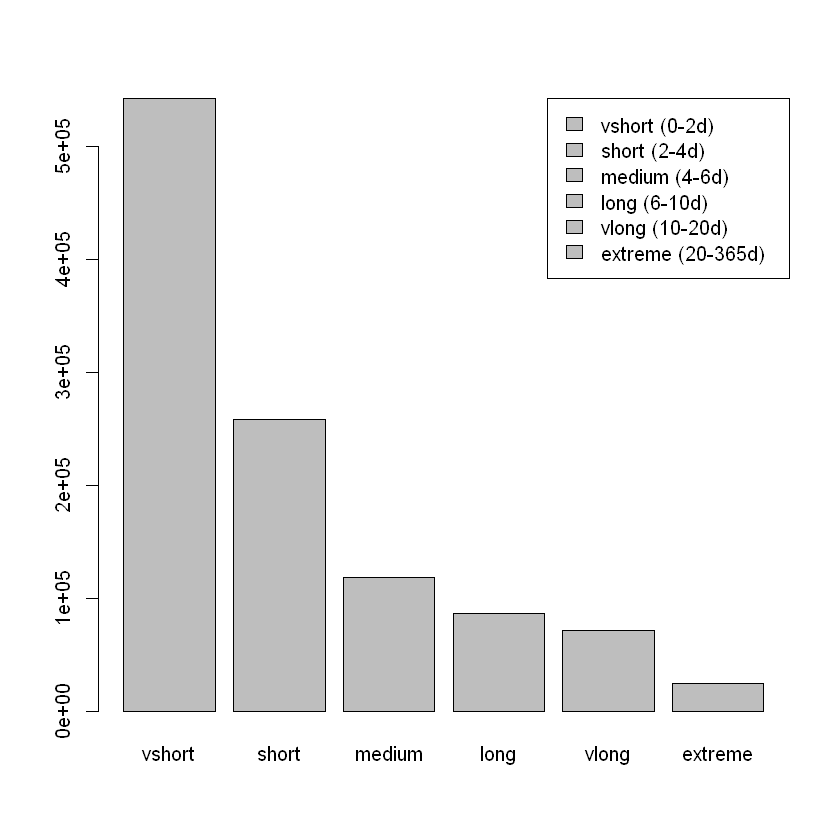

In [9]:
losbreaks <- c(0, 2, 4, 6, 10, 20, 365)
loslabels <- c('vshort', 'short', 'medium', 'long', 'vlong', 'extreme')
losdist <- data.frame(table(cut(as.numeric(dat4los$LOS), breaks=losbreaks, labels=loslabels)))

bp <- barplot(losdist$Freq, names.arg=losdist$Var1)
bp
legend("topright",
       fill=c("grey"),
       c('vshort (0-2d)', 'short (2-4d)', 'medium (4-6d)', 'long (6-10d)', 'vlong (10-20d)', 'extreme (20-365d)'))

 [Back To Top](#BackToTop)

<a id="featureeng"></a>
## Feature Engineering

Create some additional features from raw data.

### Count diagnoses present on admission

Find the columns named DXPOA1 - DXPOA25, convert them from string to integer values, perform the count, then delete the original DXPOA columns:

In [14]:
indDXPOA <- grep('DXPOA', names(dat4los))
dat4los[, indDXPOA] <- apply(dat4los[, indDXPOA], 2, FUN=function(x){ifelse(x=='Y', 1, x)}) 
dat4los[, indDXPOA] <- apply(dat4los[, indDXPOA], 2, FUN=function(x){ifelse(x==1, x, 0)})

dat4los$num_DXPOA <- apply(dat4los[, indDXPOA], 1, FUN=function(x){length(x[x=='1'])})
dat4los <- dat4los[, -indDXPOA]

### Count external causes of injury present on admission

Delete the original binary indicators.

In [15]:
indE_POA <- grep('E_POA', names(dat4los))
dat4los[, indE_POA] <- apply(dat4los[, indE_POA], 2, FUN=function(x){ifelse(x=='Y', 1, x)})
dat4los[, indE_POA] <- apply(dat4los[, indE_POA], 2, FUN=function(x){ifelse(x==1, x, 0)})

dat4los$num_E_POA <- apply(dat4los[, indE_POA], 1, FUN=function(x){length(x[x=='1'])})
dat4los <- dat4los[, -indE_POA]

### Count the number of body systems affected by chronic conditions

Delete the original binary indicators (both at the body system and individual condition levels).

In [16]:
indchronB <- grep('^CHRONB[0-9]', names(dat4los))
dat4los$num_uCHRONB <- apply(dat4los[indchronB], 1, FUN=function(x){length(unique(x[!is.na(x)]))})
dat4los <- dat4los[, -indchronB]

# Won't use these for anything either
indCHRON <- grep('^CHRON[0-9]', names(dat4los))
dat4los <- dat4los[, -indCHRON]

### Count number of payers (medicare, medicaid, private insurance, ...)

Delete the mostly-missing columns `PAY2` and `PAY3` when done.

In [17]:
indPAY <- grep('PAY', names(dat4los), value=T)
dat4los$num_PAY <- apply(dat4los[, grep('PAY', names(dat4los), value=T)],
                         1,
                         FUN=function(x){length(x[!is.na(x)])})

dat4los$PAY2 <- NULL
dat4los$PAY3 <- NULL

### Count pre-existing (comorbid) conditions

Delete the original binary indicators when done.

In [18]:
indCM <- grep('CM_', names(dat4los))
dat4los$num_CM <- apply(dat4los[, indCM], 1, FUN=function(x){(length(x[x==1]))})

dat4los <- dat4los[, -indCM]

### Remove rows with invalid point of origin values

In [19]:
indgood <- grep('[0-9A-Za-z]', dat4los$PointOfOriginUB04)
dat4los <- dat4los[indgood, ]

### Remove `HOSPT` and `DX1` columns

We will apply the model to simulated data where there is only one state, so we will derive no benefit from including the hospital state (`HOSPST`) column. We will also remove the `DX1` column (we'll use the more specific `DXCCS1` feature instead).

In [20]:
dat4los <- dat4los[, !names(dat4los) %in% c('HOSPST')]
dat4los <- dat4los[, !names(dat4los) %in% c('DX1')]

### Keep just the first three digits of the zip code

Allows us to group hospitals by larger geographical regions.

In [21]:
dat4los$ZIP3 <- substr(dat4los$ZIP, 1, 3)
dat4los$ZIP <- NULL

After this, we are left with only 24 columns for modeling:

In [22]:
dim(dat4los)

[1] 1103172      24

## Cast features and save the cleaned data

Now we ensure that the data types for these columns are properly defined as categorical or numeric:

In [23]:
# make these columns categorical
cat_cols <- c('DSHOSPID', 'FEMALE', 'RACE', 'ATYPE', 'AMONTH', 'PointOfOriginUB04', 'TRAN_IN',
              'MEDINCSTQ', 'PSTATE', 'PAY1', 'DXCCS1', 'DXMCCS1', 'ZIP3')
makecatg <- sapply(dat4los[, cat_cols], FUN=function(x){as.factor(x)})
makecatg <- as.data.frame(makecatg)
dat4los[, cat_cols] <- makecatg

# make these columns numeric
cat_num <- c('AGE', 'LOS', 'NDX', 'NCHRONIC', 'num_DXPOA', 'num_E_POA', 'num_uCHRONB', 'num_PAY', 'num_CM')
makenum <- sapply(dat4los[, cat_num], FUN=function(x){as.numeric(x)})
makenum <- as.data.frame(makenum)
dat4los[, cat_num] <- makenum

data_mod <- dat4los
str(data_mod)

'data.frame':	1103172 obs. of  24 variables:
 $ AGE              : num  32 24 49 32 0 90 61 0 60 21 ...
 $ FEMALE           : Factor w/ 2 levels "Female","Male": 1 2 1 1 1 1 1 2 2 1 ...
 $ RACE             : Factor w/ 7 levels "-9","1","2","3",..: 2 1 2 3 2 2 2 6 2 2 ...
 $ MEDINCSTQ        : Factor w/ 4 levels "1","2","3","4": 1 1 3 3 1 2 4 1 3 2 ...
 $ PSTATE           : Factor w/ 25 levels "AK","AR","AZ",..: 6 4 6 9 24 8 19 14 8 21 ...
 $ PAY1             : Factor w/ 6 levels "1","2","3","4",..: 2 3 6 2 2 1 3 2 2 2 ...
 $ KEY              : int  1 2 3 4 5 6 7 8 9 10 ...
 $ VisitLink        : Factor w/ 1000000 levels "ID.1","ID.10",..: 896051 348974 990082 300356 681789 669669 833392 732245 840761 523770 ...
 $ DSHOSPID         : Factor w/ 23 levels "hosp_1","hosp_10",..: 9 5 3 15 23 1 1 6 16 20 ...
 $ ATYPE            : Factor w/ 5 levels "ATYPE_1","ATYPE_2",..: 2 1 3 2 4 3 3 4 3 1 ...
 $ AMONTH           : Factor w/ 12 levels "1","10","11",..: 11 6 12 8 7 9 9 11 7 4 ...
 $ PointOfO

As a sanity check, we enumerate the possible values of the categorical features specifically:

In [26]:
levelinfo <- sapply(dat4los[, cat_cols], FUN=function(x){unique(x)})
str(levelinfo)
levelinfo[['FEMALE']]
levelinfo[['RACE']]
save(levelinfo, file='listoflevels.Rdata')
cat('saved the cleaned data in: ', getwd())

List of 13
 $ DSHOSPID         : Factor w/ 23 levels "hosp_1","hosp_10",..: 9 5 3 15 23 1 6 16 20 8 ...
 $ FEMALE           : Factor w/ 2 levels "Female","Male": 1 2
 $ RACE             : Factor w/ 7 levels "-9","1","2","3",..: 2 1 3 6 5 4 7
 $ ATYPE            : Factor w/ 5 levels "ATYPE_1","ATYPE_2",..: 2 1 3 4 5
 $ AMONTH           : Factor w/ 12 levels "1","10","11",..: 11 6 12 8 7 9 4 5 1 2 ...
 $ PointOfOriginUB04: Factor w/ 12 levels "1","2","4","5",..: 3 1 5 7 4 2 6 8 11 9 ...
 $ TRAN_IN          : Factor w/ 3 levels "0","1","2": 2 1 3
 $ MEDINCSTQ        : Factor w/ 4 levels "1","2","3","4": 1 3 2 4
 $ PSTATE           : Factor w/ 25 levels "AK","AR","AZ",..: 6 4 9 24 8 19 14 21 23 10 ...
 $ PAY1             : Factor w/ 6 levels "1","2","3","4",..: 2 3 6 1 4 5
 $ DXCCS1           : Factor w/ 262 levels "1","10","100",..: 93 49 199 91 132 232 201 116 104 64 ...
 $ DXMCCS1          : Factor w/ 18 levels "1","10","11",..: 3 18 11 7 14 5 2 8 13 NA ...
 $ ZIP3             : Factor 

[1] Female Male  
Levels: Female Male

[1] 1  -9 2  5  4  3  6 
Levels: -9 1 2 3 4 5 6

saved the cleaned data in:  C:/Users/mawah/Documents/GitHub/cortana-intelligence-population-health-management/ManualDeploymentGuide/Model

### Define function to evaluate model performance

Computes and returns the following common regression evaluation metrics:
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)
- Coefficient of determination (Rsquare), as a percentage
- Relative Absolute Error (RAE)
- Relative Squared Error (RSE)

In [28]:
regression_res <- function(Target, Prediction){
  res <- data.frame(Target=Target, Scored.Labels=Prediction)
  res$delta <- abs(res$Target - res$Scored.Labels)
  res$percdelta <- res$delta / res$Target
  n <- nrow(res)
    
  MAE <- sum(res$delta) / n  
  RMSE <- sqrt(sum(res$delta ^ 2) / n)
  Rsquare <- (cor(res$Target, res$Scored.Labels) ^ 2) * 100
  RAE <- sum(res$delta) / sum(abs(mean(res$Target) - res$Target))
  RSE <- sum(res$delta ^ 2) / sum(abs(mean(res$Target) - res$Target) ^ 2)
  
  results <- data.frame(MAE=MAE, RMSE=RMSE, RAE=RAE, RSE=RSE, Rsq=Rsquare)
  return(results)
}

#create a data frame for storing training and testing metrics
res_train <- data.frame(model_name='hosp_X_LOSmodel', MAE=0, RMSE=0, RAE=0, RSE=0, Rsq=0)
res_train <- res_train[-1,]
res_test <- data.frame(model_name='hosp_X_LOSmodel', MAE=0, RMSE=0, RAE=0, RSE=0, Rsq=0)
res_test <- res_test[-1,]

 [Back To Top](#BackToTop)

## Create the Models <a id="model"></a>
We will create 10 models for 10 individual hospitals and an additional model for all the other hospitals.

In [23]:
selected_hosp <- c('hosp_1', 'hosp_2', 'hosp_3', 'hosp_4', 'hosp_5', 'hosp_6', 'hosp_7',
                   'hosp_8', 'hosp_9', 'hosp_10')
allotherhosp <- unique(data_mod$DSHOSPID)[!unique(data_mod$DSHOSPID) %in% selected_hosp]
allotherhosp <- as.character(allotherhosp)
allotherhosp

[1] "hosp_17" "hosp_13" "hosp_11" "hosp_22" "hosp_14" "hosp_23" "hosp_16"
 [8] "hosp_12" "hosp_18" "hosp_15" "hosp_19" "hosp_21" "hosp_20"

For each model, we will split the available data into training and test sets with the following approach:
- Attempt to evenly split the data in each level of `DXCCS1` (the categorical feature with the most levels) to create an initial train/test partitioning.
- Because some categorical levels are rare, we may find that the training dataset does not contain some levels that are present in the test set. Remedy this by moving any such rows from the test set to the training set.
- Ensure that no patients are present in both the training and test sets (by transferring half of any offending patients to the training set, and the other half to the test set)
- Drop columns that we do not want to use for testing or training:
   - `myrownum`, `KEY`, and `VisitLink`, because they are uninformative and could result in overfitting
   - `DSHOSPID`, because most of our models will be trained on data from a single hospital

In [44]:
train_test_split <- function(input_dataset, p=0.6) {
    set.seed(18)
    train.index <- createDataPartition(sub_data_mod$DXCCS1, p=p, list=FALSE)
    train <- sub_data_mod[train.index, ]
    test  <- sub_data_mod[-train.index, ]
    
    indcc <- which(names(sub_data_mod) %in% cat_cols) # col indices for categorical cols
    toaddtotrain <- test[1, ]
    toaddtotrain <- toaddtotrain[-1, ]  # empty data frame to collect rows to add to train
    for (cc in 1:length(indcc)){
        toaddtotrain4cc <- test[!duplicated(test[, indcc[cc]]), ]  # same as unique
        toaddtotrain <- rbind(toaddtotrain, toaddtotrain4cc)
    }
    toaddtotrain <- toaddtotrain[!duplicated(toaddtotrain$myrownum), ]
    train_2 <- rbind(train, toaddtotrain)  # append rows to train
    test_2  <- test[-which(test$myrownum %in% toaddtotrain$myrownum), ] # remove rows from test
    
    vk  <- unique(test_2$VisitLink)[unique(test_2$VisitLink) %in% unique(train_2$VisitLink)]
    vk1 <- vk[1:round(length(vk) / 2)]
    vk2 <- vk[(round(length(vk) / 2) + 1):length(vk)]
    torm4mtest <- which(test_2$VisitLink %in% vk1)   # patient ids to remove from test
    train_2 <- rbind(train_2, test_2[torm4mtest, ])  # append rows with these patients to train
    test_2  <- test_2[-torm4mtest, ]                 # remove these patient rows from test
    torm4mtrain <- which(train_2$VisitLink %in% vk2) # patient ids to remove from train
    test_2  <- rbind(test_2, train_2[torm4mtrain, ]) # append rows with these patients to test
    train_2 <- train_2[-torm4mtrain, ]               # remove these patient rows from train
    
    train_2$myrownum <- NULL
    test_2$myrownum <- NULL
    train_2$KEY <- NULL
    test_2$KEY <- NULL
    train_2$VisitLink <- NULL
    test_2$VisitLink <- NULL
    train_2$DSHOSPID <- NULL
    test_2$DSHOSPID <- NULL
    
    return(list(train=train_2, test=test_2))
}

Create a folder in current working directory to save the trained models.

In [31]:
wrdir <- getwd()
modeldir <- 'myLOSmodelsfolder'
dir.create(file.path(wrdir, modeldir), showWarnings=FALSE)
modelsLocation <- paste(wrdir, modeldir, sep='/')
modelsLocation <- paste0(modelsLocation, '/')
modelsLocation

[1] "C:/Users/mawah/Documents/GitHub/cortana-intelligence-population-health-management/ManualDeploymentGuide/Model/myLOSmodelsfolder/"

In this notebook, we will use a simple linear regression model. To use xgboost, please see the notebook "Length Of Stay Models - xgboost".

In [ ]:
if(!require(xgboost)) {
    install.packages("xgboost")
    library(xgboost)
}
if(!require(caret)) {
    install.packages("caret")
    library(caret)
}

Train all of the models and store data on their performance:

In [ ]:
for (h in 1:(length(selected_hosp) + 1)) {
    cat('h =', h, '\n')
    if(h == (length(selected_hosp) + 1)) {
        cat('allotherhosp', allotherhosp, '\n')
        sub_data_mod <- subset(data_mod, data_mod$DSHOSPID %in% allotherhosp)
        cat(unique(as.character(sub_data_mod$DSHOSPID)), '\n')
        model_name <- paste('allotherhosp', '_LOSmodel', sep='')
        model_name <- paste0(modelsLocation, model_name)
        cat('model_name =' , model_name, '\n')
    } else {
        cat('selected_hosp[h]', selected_hosp[h], '\n')
        sub_data_mod <- subset(data_mod, data_mod$DSHOSPID %in% selected_hosp[h])
        cat(unique(as.character(sub_data_mod$DSHOSPID)), '\n')
        model_name <- paste(unique(as.character(sub_data_mod$DSHOSPID)), '_LOSmodel', sep='')
        model_name <- paste0(modelsLocation, model_name)
        cat('model_name =', model_name, '\n')
    }
    sub_data_mod <- sub_data_mod[complete.cases(sub_data_mod), ] # ensure all rows are complete
    sub_data_mod$myrownum <- seq(1:nrow(sub_data_mod))
    dim(sub_data_mod)
    
    results <- train_test_split(sub_data_mod)
    train <- results$train
    test <- results$test
  
    # now have the data split into training and testing ~60% training and ~40% testing  
    #----------------------------------------------------------------
    # Tune and Run the model
    mytarget     <- 'LOS'
    mypredictors <- names(train)[!names(train) %in% mytarget]
    myformulastr <- paste(mytarget, paste(mypredictors, collapse=" + "), sep=" ~ ")
    cat('myformulastr ', myformulastr, '\n')

    model_lm <- lm(as.formula(myformulastr), data=train)

    # save the model as .rds
    model_name_rds <- paste0(model_name, '.rds')
    cat('saving model_name =', model_name_rds, '\n')
    saveRDS(model_lm, model_name_rds)
   
    # Check model performance
    # model results - training data
    y_predTr <- predict(model_lm, train)
    TargetTr <- train$LOS

    res_train_lm <- regression_res(TargetTr, y_predTr) # regression_res() is defined above
    trn <- data.frame(model_name=as.character(as.data.frame(strsplit(model_name, split='/myLOSmodelsfolder/'))[2, 1]))
    trn <- cbind(trn, res_train_lm)
    res_train <- rbind(res_train, trn)

    # check how the model does on test data
    y_pred <- predict(model_lm, test)
    y_pred <- ifelse(y_pred < 1, 1, y_pred) # correcting for negative values
    Target <- test$LOS

    res_test_lm <- regression_res(Target, y_pred)     # regression_res() is defined above
    tst <- data.frame(model_name=as.character(as.data.frame(strsplit(model_name, split='/myLOSmodelsfolder/'))[2, 1]))
    tst <- cbind(tst, res_test_lm)
    res_test <- rbind(res_test, tst)
}

 [Back To Top](#BackToTop)

## Model Performance <a id="results"></a>

In [49]:
cat('Performance on training data\n')
res_train
cat('Performance on test data\n')
res_test

Performance on training data


model_name,MAE,RMSE,RAE,RSE,Rsq
hosp_1_LOSmodel,1.761187,3.056545,0.5688672,0.2793405,72.06595
hosp_2_LOSmodel,1.962650,3.268309,0.5477457,0.2868737,71.31263
hosp_3_LOSmodel,2.070889,3.632514,0.5372024,0.2408658,75.91342
hosp_4_LOSmodel,2.044856,3.531632,0.5375088,0.2569438,74.30562
hosp_5_LOSmodel,1.855186,3.009658,0.5481659,0.2669093,73.30907
hosp_6_LOSmodel,1.602218,2.743962,0.5363763,0.2772800,72.27200
hosp_7_LOSmodel,1.678801,2.753826,0.5577385,0.2686688,73.13312
hosp_8_LOSmodel,1.719537,2.925290,0.5573140,0.2696085,73.03915
hosp_9_LOSmodel,1.899629,3.127434,0.5773648,0.2965665,70.34335
hosp_10_LOSmodel,2.074107,3.507936,0.5383274,0.2758796,72.41204


Performance on test data


model_name,MAE,RMSE,RAE,RSE,Rsq
hosp_1_LOSmodel,1.671868,3.041515,0.5335986,0.2826987,71.79091
hosp_2_LOSmodel,1.850933,3.222738,0.5216710,0.2773806,72.41747
hosp_3_LOSmodel,1.958407,3.961695,0.5054750,0.2568631,74.47601
hosp_4_LOSmodel,1.946494,3.559375,0.5069730,0.2705469,73.02307
hosp_5_LOSmodel,1.769977,3.020131,0.5298543,0.2670209,73.34981
hosp_6_LOSmodel,1.552580,2.950353,0.5158293,0.2874858,71.54671
hosp_7_LOSmodel,1.630344,2.940318,0.5343276,0.2665996,73.36230
hosp_8_LOSmodel,1.649459,2.930763,0.5354212,0.2941037,70.61512
hosp_9_LOSmodel,1.802536,3.045456,0.5526677,0.2916476,70.89384
hosp_10_LOSmodel,1.991844,3.548127,0.5239971,0.2913907,71.05457
